In [12]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02
r2 = 1

eq = Dt(u(t, x)) ~ Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * Dxx(u(t,x)))

bcs = [u(0, x) ~ cospi(x)-exp(-4*π*π*abs2(x)),
    u(t, -1.0) ~ u(t, 1.0),
    Dx(u(t, -1.0)) ~ Dx(u(t, 1.0))]

domains = [t ∈ Interval(0.0, 0.25),
    x ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem(eq, bcs, domains, [t,x], [u(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) ~ Differential(x)(Differential(x)(u(t, x)^3 - 0.02Differential(x)(Differential(x)(u(t, x))) - u(t, x)))]
Boundary Conditions: Equation[u(0, x) ~ cospi(x) - exp(-39.47841760435743abs2(x)), u(t, -1.0) ~ u(t, 1.0), Differential(x)(u(t, -1.0)) ~ Differential(x)(u(t, 1.0))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..0.25), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [13]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = QuasiRandomSampler(1000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (100,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-0.5386627912521362 1.5582267045974731; 1.991929531097412 -0.09577541798353195; … ; -0.4733268618583679 -1.5853675603866577; 0.1954130381345749 -1.082320213317871], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.5370195508003235 0.5638769865036011 … -0.07387085258960724 0.6608429551124573; -0.6040573120117188 -0.32470741868019104 … 0.20104482769966125 0.6971802115440369; … ; 0.557422399520874 -0.2192048728466034 … 0.7208107113838196 0.5727482438087463; 0.5951223373413086 -0.4111434817314148 … -0.4710530638694763 -0.6651031374931335], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.24150630831718445 -0.22274662554264069 … 0.38873568177223206 -0.46499529480934143; 0.543647289276123 -0.6152505278587341 … -0.20794226229190826 0.5516670346260071; … ; -0.5870752334594727 -0.14728426933288574 … 0.2803768813610077 0.6341552734375; -0.10604557394981384 -0.1449953019618988 … -0.17302045

In [14]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 77907.20357835328


Loss: 5.659097607584907


Loss: 0.9369346600711415


Loss: 0.4431025440620505


Loss: 0.046335294983777114


Loss: 0.011075294709975621


Loss: 0.0035521152061379025


Loss: 0.0010856901722733551


Loss: 0.0004821761364173165


Loss: 0.00026248849501052146


Loss: 0.00017077378154857668


u: ComponentVector{Float64}(layer_1 = (weight = [0.40194976445453023 1.5260736955860474; 5.26081739338062 0.23180224466043858; … ; -2.0585230072019836 -0.6979718056925401; -0.18351279440033494 -0.7115991280608063], bias = [-0.7981321213653033; 0.6043527612332309; … ; -0.016471324713741662; -0.02237298680002165;;]), layer_2 = (weight = [-0.515159513145308 0.36903295456058394 … -0.08863901836212561 0.49694144969423165; -0.6699847046655082 -0.7173857656963164 … 0.2118480057000574 0.8950758161271257; … ; 0.7577351697278569 -0.4854158579113223 … 1.1098143167278736 0.8981613914347749; 0.3375356338701183 -0.28215506588973116 … 0.2666122607520043 -0.5571328895608845], bias = [-0.41950978671464656; 0.1402773683955731; … ; -0.29647765377971136; 0.08060527662053094;;]), layer_3 = (weight = [-0.0449504009173851 -0.4305505292959506 … 0.2871966819788088 -0.6507363164969368; 0.1698431177225843 -1.3044139822675074 … -1.031883715957972 0.7123768290687803; … ; -0.5261767408122602 -0.11561590263444971 … 

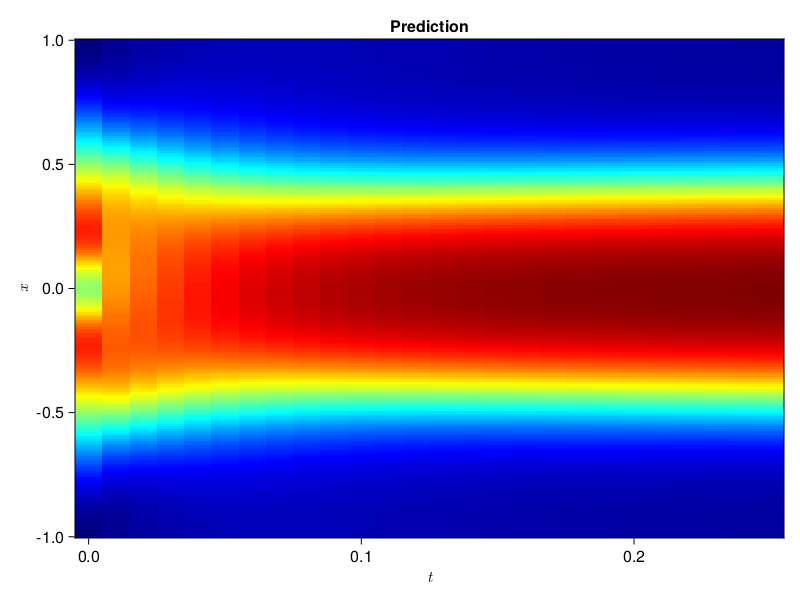

In [15]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts = 0.0:0.01:1.0
xs = -1.0:0.01:1.0

axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [18]:
# sequential training
for tmax in [0.5, 0.75, 1.0]
    i = 0
    pde_system.domain[1] = t ∈ 0.0..tmax
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; u0=res.u, p=data)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
    u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end

Loss: 3.2986215201065776


Loss: 0.0011902355908056594


In [6]:
using JLD2
jldsave("cahn-hilliard_finitediff.jld2"; pde=pde_system, pinn=pinn, res=res, prob=prob)

Loss: 0.6842902725954241


# Improve accuracy with taylordiff

In [ ]:
using TaylorDiff
prob = Sophon.discretize(pde_system, pinn, sampler, strategy; derivative=Sophon.taylordiff)
prob = remake(prob; u0=res.u)
i=0
res2 = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

In [ ]:
phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [ ]:
using JLD2
jldsave("cahn-hilliard_finitediff_taylordiff.jld2"; pde=pde_system, pinn=pinn, res=res2, prob=prob)